# Import Library

In [ ]:
import numpy as np
import tensorflow as tf
import os
import zipfile
import shutil
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
from PIL import Image
from tensorflow.python.framework import ops
import math
import glob
from shutil import copyfile
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# import seaborn as sns

In [ ]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Data Loading

In [ ]:
id='1pOa0wYI0q0z7-XuWnYwBrO3io-J6bgFM'
id2='1Io_ZfD4ARm-vRBJoRURZ8d_lPkEbx6YU'
id3='1fWujUHcSCRzQzeUxqFGkrSBFwunGM1ic'

In [ ]:
downloaded = drive.CreateFile({'id':id3})  #drive from PyDrive
downloaded.GetContentFile('cassava-disease.zip')

In [ ]:
local_zip='./cassava-disease.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/')
zip_ref.close()

# EDA

In [ ]:
list_directory=os.listdir('./data/train/')
print(list_directory)

['healthy', 'cgm', 'cmd', 'cbb']


healthy


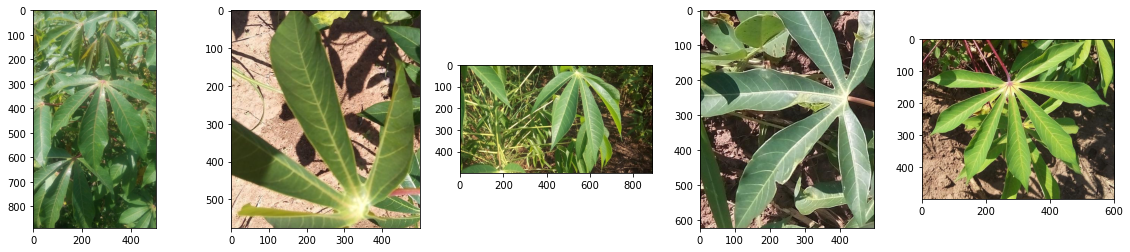

cgm


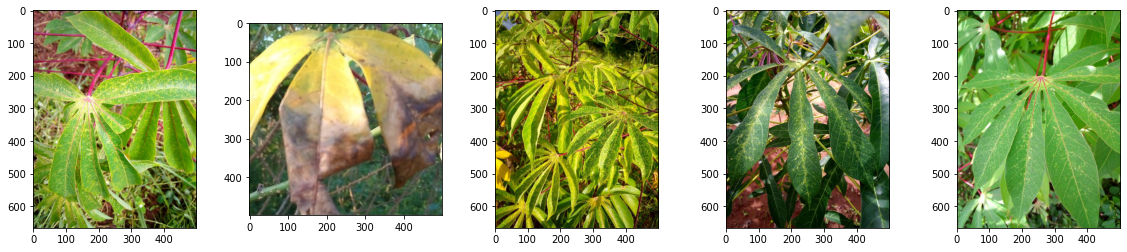

cmd


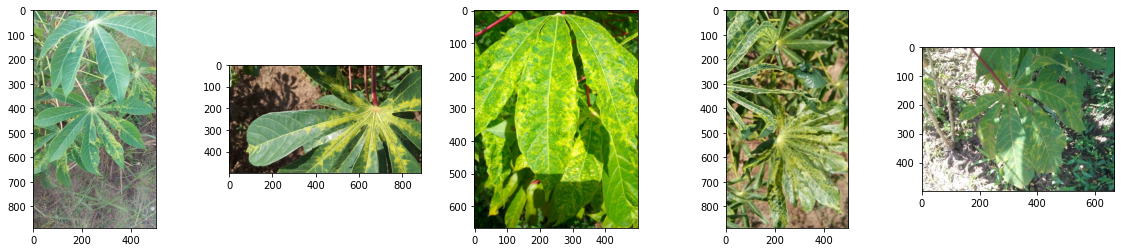

cbb


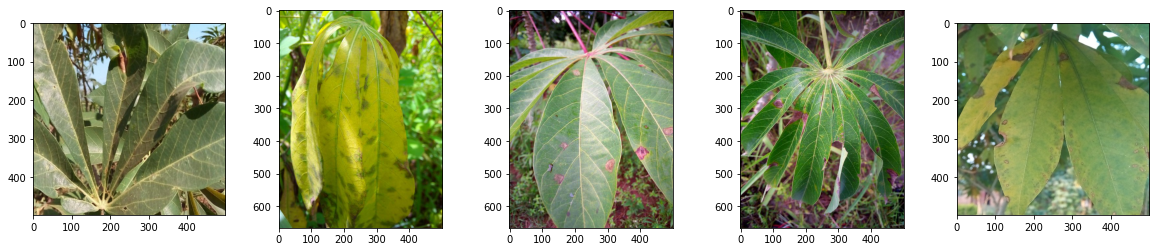

In [ ]:
#checking image on directory
imdir='./data/train/'
for  images in list_directory:
  print(images)
  class_dir = os.path.join(imdir,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D

In [ ]:
findir='./siuu/train/'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,
                      restore_best_weights=True, verbose=1)

checkpoint_cb = ModelCheckpoint("Cassava_best_modelEffNetB3.h5",
                            save_best_only=True,
                            monitor = 'val_loss',
                            mode='min')

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.3,
                          patience = 3,
                          min_lr = 1e-6,
                          mode = 'min',
                          verbose = 1)

# Model 2 with Generated Data

In [ ]:
diseases=('cbb','cgm','cmd','healthy')

In [ ]:
def load_image_array(alldata_dir, disease):
  temp_dis_dir = os.path.join(imdir, disease)
  temp_files = os.listdir(temp_dis_dir)
  temp_paths = [os.path.join(temp_dis_dir, file) for file in temp_files]
  temp_imgs = [read_image(file) for file in temp_paths]

  return np.array(temp_imgs)

def image_pixel_normalization(image):
  """
  transform image to same size without cropping the image
  e.g. image size : (200, 600) => (600, 600)
  """
  h, w, _ = image.shape

  norm_size = h if h > w else w
  
  add_h = norm_size - h
  add_w = norm_size - w 
  
  start_add_h = add_h // 2
  start_add_w = add_w // 2

  new_img = np.full((norm_size, norm_size, 3), 255, dtype=np.uint8)
  new_img[start_add_h:start_add_h + h, start_add_w:start_add_w + w, :] = image
  
  return new_img

def preprocessing(image):
  """
  preprocessing image including size normalization and resize image
  """
  img = image_pixel_normalization(image)
  img = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
  return np.array(img)

def read_image(image_file):
  img = cv2.imread(image_file)
  img = preprocessing(img)
  return np.array(img)

In [ ]:
disease_imgs = {}

for disease in diseases:
  disease_imgs[disease] = load_image_array(imdir, disease)
  print(disease, "done") 

disease_imgs.keys()

cbb done
cgm done
cmd done
healthy done


dict_keys(['cbb', 'cgm', 'cmd', 'healthy'])

In [ ]:
disease_imgs['cbb'].shape

(466, 300, 300, 3)

In [ ]:
shutil.rmtree('siuu/train', ignore_errors=True)
finaldata_dir = "./siuu/train/"

In [ ]:
os.mkdir(finaldata_dir)
for disease in diseases:
  os.mkdir(os.path.join(finaldata_dir, disease))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D

In [ ]:
datagen = ImageDataGenerator(
            rotation_range=40, # rotation
            # width_shift_range=0.15, # horizontal shift
            # height_shift_range=0.15, # vertical shift
            # zoom_range=0.1, # zoom
            horizontal_flip=True, # horizontal flip
            vertical_flip=True, # vertical flip
            # brightness_range=[0.75,1.25], # brightness
          )

def generate_image(datagen, data, amount, savepath=None):
  # prepare iterator
  it = datagen.flow(
        data, 
        batch_size=1, 
        save_to_dir=savepath,
        save_prefix='',
        save_format='png',
      )
  
  # generate samples and plot
  for i in range(amount):
    batch = it.next()
    image = batch[0].astype('uint8')

In [ ]:
amount = 1000

for idx, disease in enumerate(diseases):
  save_path = os.path.join(finaldata_dir, disease)
  generate_image(datagen, disease_imgs[disease], amount, save_path)
  print("{} (done) : {}".format(disease, len(os.listdir(save_path))))

cbb (done) : 1000
cgm (done) : 1000
cmd (done) : 1000
healthy (done) : 1000


In [ ]:
!zip -r finaldata.zip siuu/train/

  adding: siuu/train/ (stored 0%)
  adding: siuu/train/healthy/ (stored 0%)
  adding: siuu/train/healthy/_22_8252.png (deflated 0%)
  adding: siuu/train/healthy/_218_1482.png (deflated 0%)
  adding: siuu/train/healthy/_285_1275.png (deflated 0%)
  adding: siuu/train/healthy/_279_1344.png (deflated 0%)
  adding: siuu/train/healthy/_64_8112.png (deflated 0%)
  adding: siuu/train/healthy/_131_7732.png (deflated 0%)
  adding: siuu/train/healthy/_74_7483.png (deflated 0%)
  adding: siuu/train/healthy/_207_9824.png (deflated 0%)
  adding: siuu/train/healthy/_160_8177.png (deflated 0%)
  adding: siuu/train/healthy/_304_4212.png (deflated 0%)
  adding: siuu/train/healthy/_271_7577.png (deflated 0%)
  adding: siuu/train/healthy/_87_9545.png (deflated 0%)
  adding: siuu/train/healthy/_74_1766.png (deflated 1%)
  adding: siuu/train/healthy/_271_2413.png (deflated 0%)
  adding: siuu/train/healthy/_261_2780.png (deflated 0%)
  adding: siuu/train/healthy/_219_2559.png (deflated 0%)
  adding: siuu/tr

healthy


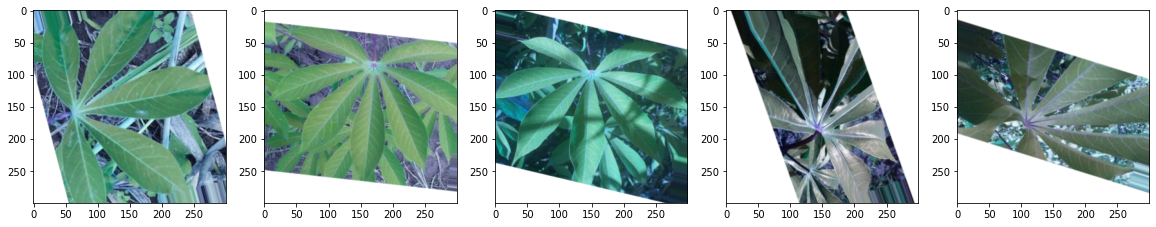

cgm


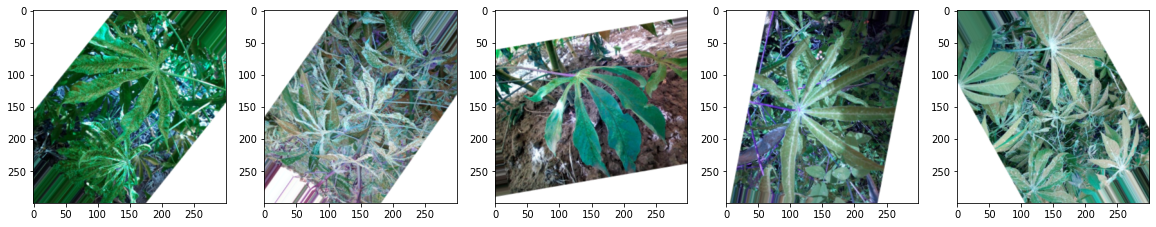

cmd


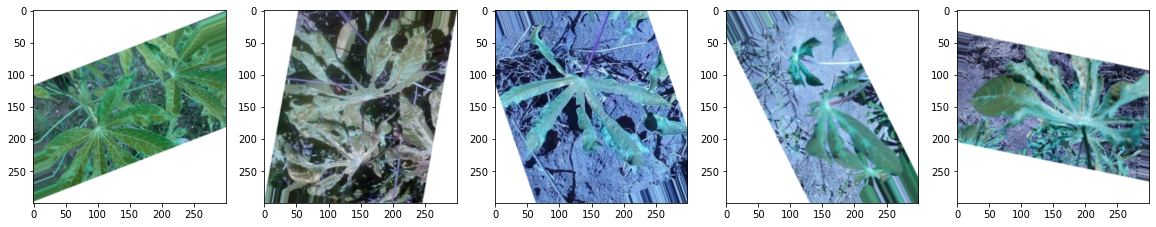

cbb


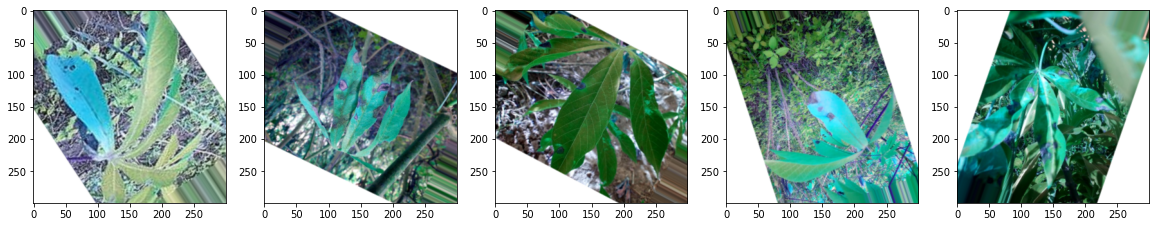

In [ ]:
#checking image on directory
findir='./siuu/train/'
for  images in list_directory:
  print(images)
  class_dir = os.path.join(findir,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

# Image Preprocessing

In [ ]:
image_shape=224
datagen = ImageDataGenerator(
       rotation_range=40, # rotation
            width_shift_range=0.15, # horizontal shift
            height_shift_range=0.15, # vertical shift
            zoom_range=0.1, # zoom
            rescale=1.0/255,
            horizontal_flip=True, # horizontal flip
            vertical_flip=True, # vertical flip
            brightness_range=[0.75,1.25], # brightness
            validation_split=0.2
)

val_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)
batch_size = 70

train_generator = datagen.flow_from_directory(
    findir,
    target_size =(224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    
)

validation_generator = val_datagen.flow_from_directory(
    findir,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


# Create Save Model Dir

In [ ]:
saved_model_dir = "saved_model"
saved_model_his = "saved_model_history"
tflite_model_dir = "tflite_model"

if not(os.path.isdir(saved_model_dir)): os.mkdir(saved_model_dir)
if not(os.path.isdir(saved_model_his)): os.mkdir(saved_model_his)
if not(os.path.isdir(tflite_model_dir)): os.mkdir(tflite_model_dir)

# Save Model Function


In [ ]:
# save model method
def saved_model(modelname, model):
  export_path = os.path.join(saved_model_dir, modelname)
  if os.path.isdir(export_path):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(export_path, ignore_errors=True)

  model.save(export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# Convert to tflite

In [ ]:
# convert saved model to TFLite model
def tflite_model_convert(modelname, tflitedir):
  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(saved_model_dir, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_model_dir, tflitedir)

  if os.path.isdir(tflite_dir):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(tflite_dir, ignore_errors=True)

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "Cassava_{}.tflite".format(tflitedir.lower()))
  label_file = os.path.join(tflite_dir, "Cassava_{}.txt".format(tflitedir.lower()))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(label_types))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [ ]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['cbb', 'cgm', 'cmd', 'healthy']

In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,weights='imagenet',input_shape=(image_shape,image_shape,3))
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,
                      restore_best_weights=True, verbose=1)

checkpoint_cb = ModelCheckpoint("Cassava_best_modelEffNetB3.h5",
                            save_best_only=True,
                            monitor = 'val_loss',
                            mode='min')

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.3,
                          patience = 3,
                          min_lr = 1e-6,
                          mode = 'min',
                          verbose = 1)

In [ ]:
try:
    with tf.device('/device:GPU:0'):
        inputs = tf.keras.layers.Input(shape=(image_shape,image_shape,3))
        x = base_model(inputs)
        x = tf.keras.layers.GaussianNoise(0.2)(x)
        # x=tf.keras.layers.Dropout(0.5)(x)
       
        
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(4,activation="softmax")(x)

        model4 = tf.keras.Model(inputs=[inputs],outputs=[outputs])

        model4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                      loss='categorical_crossentropy',
                      #loss=tfa.losses.SigmoidFocalCrossEntropy(),
                      metrics=['accuracy'])

        history=model4.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=[es,reduce_lr,checkpoint_cb]
                           )
except RuntimeError as e:
    print(e)   

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

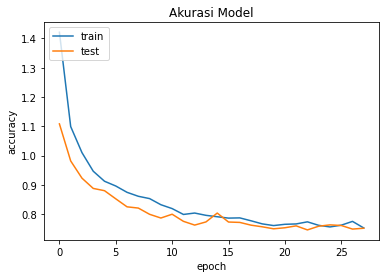

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
y_test = validation_generator.classes
y_pred = model4.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels, rotation=45)
ax.yaxis.set_ticklabels(labels, rotation=45)

## Display the visualization of the Confusion Matrix.
plt.show()

# Model 3

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
model2 = Sequential()
    # initialize the model with input shape as (224,224,3)
model2.add(tf.keras.applications.DenseNet121(input_shape = (image_shape, image_shape, 3), include_top = False, weights = 'imagenet' ))
model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(256, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model2.add(Dropout(0.7))
model2.add(Dense(32, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model2.add(Dropout(0.7))
model2.add(Dense(4, activation = 'softmax'))


29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                      

In [ ]:
EPOCHS = 5
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [ ]:
model2.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [ ]:
 history = model2.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 32,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=[es,reduce_lr,checkpoint_cb]
                            )

Epoch 1/30
45/45 [==============================] - 101s 2s/step - loss: 1.7934 - accuracy: 0.2540 - val_loss: 1.3603 - val_accuracy: 0.3260 - lr: 2.0000e-04
Epoch 2/30
45/45 [==============================] - 67s 1s/step - loss: 1.4355 - accuracy: 0.2872 - val_loss: 1.3257 - val_accuracy: 0.4026 - lr: 2.0000e-04
Epoch 3/30
45/45 [==============================] - 69s 2s/step - loss: 1.3173 - accuracy: 0.3696 - val_loss: 1.1683 - val_accuracy: 0.5753 - lr: 2.0000e-04
Epoch 4/30
45/45 [==============================] - 69s 2s/step - loss: 1.1854 - accuracy: 0.4690 - val_loss: 0.9904 - val_accuracy: 0.6026 - lr: 2.0000e-04
Epoch 5/30
45/45 [==============================] - 70s 2s/step - loss: 1.0657 - accuracy: 0.5431 - val_loss: 0.8098 - val_accuracy: 0.7416 - lr: 2.0000e-04
Epoch 6/30
45/45 [==============================] - 65s 1s/step - loss: 0.9904 - accuracy: 0.5927 - val_loss: 1.0813 - val_accuracy: 0.6883 - lr: 2.0000e-04
Epoch 7/30
45/45 [==============================] - 66s 1

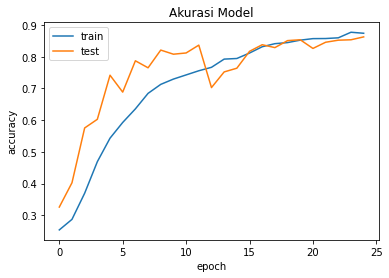

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

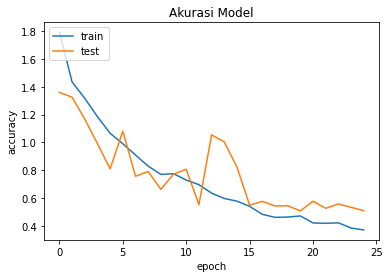

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:

model2.evaluate(train_generator)

46/46 [==============================] - 52s 1s/step - loss: 0.2066 - accuracy: 0.9425


[0.2065817266702652, 0.9424999952316284]

In [ ]:
model2.evaluate(validation_generator)

12/12 [==============================] - 6s 467ms/step - loss: 0.4918 - accuracy: 0.8587


[0.49179744720458984, 0.8587499856948853]

In [ ]:
y_test = validation_generator.classes
y_pred = model2.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


# See Confussion Matrix

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

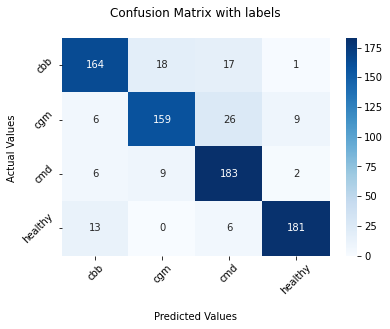

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)


ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

## Display the visualization of the Confusion Matrix.
plt.show()

# Test predict for model 3

Saving cgmv2.jpg to cgmv2.jpg
Cassava Green Mottle


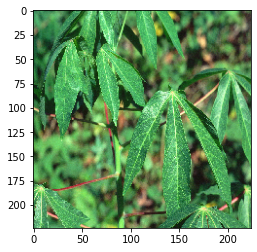

In [ ]:
from google.colab import files
from keras.preprocessing import image
 
uploaded = files.upload()
 
for path in uploaded.keys():
  img = image.load_img(path, target_size=(image_shape,image_shape))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  images /= 255 # because on train and test image is normalized, on image predict supposed to be too.
  classes = model2.predict(images, batch_size=100) # the value is not always 1 and 0 because of probabilities
  predicted_class_indices=np.argmax(classes) # use to check prediction that have higher probabilities

if predicted_class_indices == 0:
    print('Cassava Bacterial Blight')

elif predicted_class_indices == 1:
  print('Cassava Green Mottle')
elif predicted_class_indices == 2:
  print('cassava mosaic disease ')
elif predicted_class_indices == 3:
  print('Healthy')
else:
  print('')

# Save Model 3

In [ ]:
best_model = tf.keras.models.load_model('Cassava_best_modelEffNetB3.h5')

In [ ]:
modelname = "BestMC_DenseNetModel"
saved_model(modelname, best_model)

INFO:tensorflow:Assets written to: saved_model/BestMC_DenseNetModel/assets
Export path:  saved_model/BestMC_DenseNetModel
['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']


In [ ]:
modelname = "BestMC_DenseNetModel"
tflitedir = "DenseModel"
tflite_model_convert(modelname, tflitedir)

Export path:  tflite_model/DenseModel
['Cassava_densemodel.tflite', 'Cassava_densemodel.txt']


In [ ]:
# clear best model h5 format
os.remove('Cassava_best_modelEffNetB3.h5')

# Model 4

In [ ]:
model = tf.keras.Sequential([
    tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(image_shape, image_shape, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
    tf.keras.layers.Dense(32, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),

    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                      

In [ ]:
model.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [ ]:
 history = model.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 32,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=[es,reduce_lr,checkpoint_cb]
                            )

Epoch 1/30
45/45 [==============================] - 78s 1s/step - loss: 0.9713 - accuracy: 0.5917 - val_loss: 0.8729 - val_accuracy: 0.6974 - lr: 2.0000e-04
Epoch 2/30
45/45 [==============================] - 65s 1s/step - loss: 0.5724 - accuracy: 0.7898 - val_loss: 0.6652 - val_accuracy: 0.7714 - lr: 2.0000e-04
Epoch 3/30
45/45 [==============================] - 69s 2s/step - loss: 0.4582 - accuracy: 0.8466 - val_loss: 0.6070 - val_accuracy: 0.7792 - lr: 2.0000e-04
Epoch 4/30
45/45 [==============================] - 69s 2s/step - loss: 0.3789 - accuracy: 0.8725 - val_loss: 0.5060 - val_accuracy: 0.8221 - lr: 2.0000e-04
Epoch 5/30
45/45 [==============================] - 76s 2s/step - loss: 0.3286 - accuracy: 0.8955 - val_loss: 0.6594 - val_accuracy: 0.7987 - lr: 2.0000e-04
Epoch 6/30
45/45 [==============================] - 67s 1s/step - loss: 0.2884 - accuracy: 0.8997 - val_loss: 0.5457 - val_accuracy: 0.8130 - lr: 2.0000e-04
Epoch 7/30
45/45 [==============================] - ETA: 0

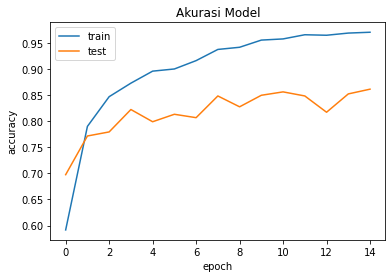

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

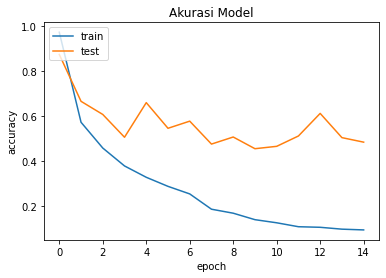

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# Conf Matrix Model4

In [ ]:
y_test = validation_generator.classes
y_pred = model.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


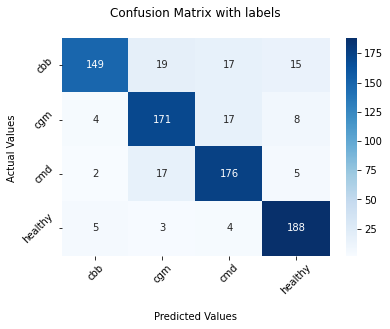

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)


ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

## Display the visualization of the Confusion Matrix.
plt.show()

# Save Model 4

In [ ]:
best_model = tf.keras.models.load_model('Cassava_best_modelEffNetB3.h5')

In [ ]:
modelname = "overfit_DenseNetModel"
saved_model(modelname, best_model)

INFO:tensorflow:Assets written to: saved_model/overfit_DenseNetModel/assets


INFO:tensorflow:Assets written to: saved_model/overfit_DenseNetModel/assets


Export path:  saved_model/overfit_DenseNetModel
['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']


In [ ]:
modelname = "overfit_DenseNetModel"
tflitedir = "OverfitDenseModel"
tflite_model_convert(modelname, tflitedir)

Export path:  tflite_model/OverfitDenseModel
['Cassava_overfitdensemodel.tflite', 'Cassava_overfitdensemodel.txt']


In [ ]:
# clear best model h5 format
os.remove('Cassava_best_modelEffNetB3.h5')

# Model 5

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 

model5 = tf.keras.models.Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_shape=(image_shape,image_shape,3)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  
])

model5.layers[0].trainable = False

model5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)              

In [ ]:
model5.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [ ]:
 history5 = model5.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 32,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=[es,reduce_lr,checkpoint_cb]
                            )

Epoch 1/30
45/45 [==============================] - 59s 1s/step - loss: 2.1311 - accuracy: 0.5633 - val_loss: 1.9180 - val_accuracy: 0.6792 - lr: 2.0000e-04
Epoch 2/30
45/45 [==============================] - 54s 1s/step - loss: 1.8212 - accuracy: 0.6923 - val_loss: 1.7898 - val_accuracy: 0.6753 - lr: 2.0000e-04
Epoch 3/30
45/45 [==============================] - 53s 1s/step - loss: 1.7338 - accuracy: 0.7029 - val_loss: 1.7143 - val_accuracy: 0.7117 - lr: 2.0000e-04
Epoch 4/30
45/45 [==============================] - 53s 1s/step - loss: 1.6351 - accuracy: 0.7294 - val_loss: 1.6553 - val_accuracy: 0.7130 - lr: 2.0000e-04
Epoch 5/30
45/45 [==============================] - 53s 1s/step - loss: 1.6003 - accuracy: 0.7281 - val_loss: 1.6345 - val_accuracy: 0.7065 - lr: 2.0000e-04
Epoch 6/30
45/45 [==============================] - 53s 1s/step - loss: 1.5307 - accuracy: 0.7345 - val_loss: 1.6171 - val_accuracy: 0.7000 - lr: 2.0000e-04
Epoch 7/30
45/45 [==============================] - 53s 1s

# Save Model 5

In [ ]:
best_model = tf.keras.models.load_model('Cassava_best_modelEffNetB3.h5')

In [ ]:
modelname = "MobileNetV2_Model"
saved_model(modelname, best_model)

In [ ]:
modelname = "MobileNetV2_Model"
tflitedir = "DenseModel"
tflite_model_convert(modelname, tflitedir)

In [ ]:
# zip all model directory and download it
!zip -r all_models.zip saved_model

# zip all model history directory and download it
!zip -r all_models_history.zip saved_model_history

# zip all model directory and download it
!zip -r all_tflite_models.zip tflite_model

updating: saved_model/ (stored 0%)
updating: saved_model/overfit_DenseNetModel/ (stored 0%)
updating: saved_model/overfit_DenseNetModel/assets/ (stored 0%)
updating: saved_model/overfit_DenseNetModel/keras_metadata.pb (deflated 96%)
updating: saved_model/overfit_DenseNetModel/saved_model.pb (deflated 92%)
updating: saved_model/overfit_DenseNetModel/variables/ (stored 0%)
updating: saved_model/overfit_DenseNetModel/variables/variables.index (deflated 80%)
updating: saved_model/overfit_DenseNetModel/variables/variables.data-00000-of-00001 (deflated 11%)
updating: saved_model/BestMC_DenseNetModel/ (stored 0%)
updating: saved_model/BestMC_DenseNetModel/assets/ (stored 0%)
updating: saved_model/BestMC_DenseNetModel/keras_metadata.pb (deflated 96%)
updating: saved_model/BestMC_DenseNetModel/saved_model.pb (deflated 92%)
updating: saved_model/BestMC_DenseNetModel/variables/ (stored 0%)
updating: saved_model/BestMC_DenseNetModel/variables/variables.index (deflated 80%)
updating: saved_model/Be